# Kaggle in Class

In [1]:
# подгружаем все необходимые модули
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import model_selection, cross_validation, preprocessing, ensemble, metrics
from sklearn.metrics import average_precision_score, roc_auc_score
import xgboost as xgb
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# подгружаем датасет
train_data = pd.read_csv('Train.csv', sep =',')

In [3]:
train_data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1


In [4]:
from sklearn.utils import shuffle

# так как классы не сбалансированы проводим oversampling, добавляем необходимое количество строк с классом "отток" так, 
# чтобы была пропорция классов примерно 1:1
def oversampling(data):
    dataChurn = data[data['labels'] == 1]
    dataNoChurn = data[data['labels'] == -1]
    alpha = (int)(dataNoChurn.shape[0]/dataChurn.shape[0])
    print alpha
    dataChurnRet = dataChurn 
    for i in range(alpha):
        dataChurnRet = dataChurnRet.append(dataChurn)
    dataNoChurn = dataNoChurn.append(dataChurnRet)
    dataNoChurn = shuffle(dataNoChurn)
    return dataNoChurn.iloc[:,:230], dataNoChurn.iloc[:,230:]

# ради эксперимента попробовал undersampling. Результаты не намного хуже, чем с oversampling'ом
def undersampling(data):
    dataChurn = data[data['labels'] == 1]
    dataNoChurn = data[data['labels'] == -1]
    countFirst = len(dataChurn)
    dataChurn = dataChurn.append(dataNoChurn.iloc[:countFirst,:])
    dataChurn = shuffle(dataChurn)
    return dataChurn.iloc[:,:230], dataChurn.iloc[:,230:]

In [5]:
# для преобразования категориальных фич был использован preprocessing.LabelEncoder
def labelEncoder(data, kaggle):
    data = data.fillna(0)
    le = preprocessing.LabelEncoder()
    for m in range(190,230):
        # для labelEncoder'а тестовые и обучающие данные были объединены,
        # тк в тестовых данных присутствуют категории не встречающиеся в обучении.
        le.fit(data.iloc[:,m].append(kaggle.iloc[:,m]))
        data.iloc[:,m] = le.transform(data.iloc[:,m])       
        kaggle.iloc[:,m] = le.transform(kaggle.iloc[:,m])
    return data, kaggle

# удаление неинформативных фич
# Неинформативными считаю фичи, в которых одно константное значение 
def dropUninformative(data):
    df = pd.DataFrame([])
    for i in range(data.shape[1]):
        if len(np.unique(data.iloc[:,i]))>1:
            df["Var"+str(i)] = data.iloc[:,i]
    return df

# отбор фич, наиболее информативных для модели, и отображение графиков для наглядности
def featureImportance(estimator, data):
    fig = plt.figure(figsize=(20, 70))
    ax = fig.add_subplot(111)

    df_f = pd.DataFrame(estimator.feature_importances_, columns=["importance"])
    df_f["labels"] = data.columns.values
    df_f.sort_values("importance", inplace=True, ascending=False)
    display(df_f.head(90))

    index = np.arange(len(estimator.feature_importances_))
    bar_width = 0.5
    rects = plt.barh(index , df_f["importance"], bar_width, alpha=0.4, color='b', label='Main')
    plt.yticks(index, df_f["labels"])
    plt.show()
    return df_f


In [17]:
# кросс-валидация ведется с помощью StratifiedKFold, количество фолдов - 5. + f1 score
def KFold(estimator, x_data, y_data):
    skf = cross_validation.StratifiedKFold(y_data.iloc[:,0], n_folds=4)
    y_scores = pd.DataFrame()
    y_tests = pd.DataFrame()
    y_pred = pd.DataFrame() 
    f1 = np.array([])
    n = 0
    for train_index, test_index in skf:
        print x_data.iloc[train_index, :].shape
        estimator.fit(x_data.iloc[train_index, :], y_data.iloc[train_index, 0])
        print x_data.iloc[test_index, :].shape
        y_scores['fold_'+str(n)] = estimator.predict(x_data.iloc[test_index, :])
        y_pred['fold_'+str(n)] = estimator.predict(x_data.iloc[test_index, :])
        y_tests['fold_'+str(n)] = y_data.iloc[test_index, 0].values
        f1 = np.append(f1, metrics.f1_score(y_data.iloc[test_index, 0], y_pred.iloc[:,n])) 
        n+=1
    print 'mean f1 score: '+str(np.mean(f1))
    return  y_scores, y_tests

# построение AUC_PRC        
def PRC(y_sores, y_tests):
    plt.figure(figsize = (7,7))
    mean_PR = np.array([])
    n = 0
    for i, j in zip(y_scores, y_tests):
        precision, recall, _ = metrics.precision_recall_curve(y_tests[i], y_scores[j])
        average_precision = metrics.average_precision_score(y_tests[i], y_scores[j])
        mean_PR = np.append(mean_PR, average_precision)
        plt.plot(recall, precision, color='b', alpha=0.5, label='PR fold '+str(n) + ' (score = %0.2f)' % average_precision)
        plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
        n+=1
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="upper right")
    plt.title('2-class Precision-Recall curve: Mean PR={0:0.3f}'.format(mean_PR.mean()))
    plt.show()
    
# построение AUC_ROC  
def ROC(y_scores, y_test):
    plt.figure(figsize = (7,7))
    Mean_ROC = np.array([])
    n = 0
    for i, j in zip(y_scores, y_tests):
        fpr, tpr, thresholds = metrics.roc_curve(y_tests[i], y_scores[j])
        roc_auc = metrics.auc(fpr, tpr)
        lw = 2
        Mean_ROC = np.append(Mean_ROC, roc_auc)
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC fold '+str(n)+' (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        n += 1
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title('2-class ROC curve: Mean ROC area={0:0.3f}'.format(Mean_ROC.mean()))
    plt.show()

## Обработка данных:

Пропущенные значения в данных будут заполняться нулями, будет проведен oversampling, для категориальные признаков будет использоваться labelEncoder. В дальнейшем будет осуществлен отбор признаков по построенной модели.

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# проводим oversampling данных
x_data, y_data = oversampling(train_data)
# подгружаем тестовые данные для Kaggle
test_kaggle = pd.read_csv('./orange_small_churn_test_data.csv', sep=',')
# удаляем ненужную колонку ID из тестовых данных
del test_kaggle['ID']
# заполняем пропуски в данных нулями
x_test_kaggle = test_kaggle.fillna(0)
train_data = train_data.fillna(0)

# используем labelEncoder для категориальных фич
x_data, x_test_kaggle = labelEncoder(x_data, x_test_kaggle)
# удаляем неинформативные фичи
temp = dropUninformative(pd.DataFrame.append(x_data,x_test_kaggle))
# разделяем полученный массив данных на обучение и тест
x_data = temp.iloc[:temp.shape[0]-x_test_kaggle.shape[0],:]
x_test_kaggle = temp.iloc[temp.shape[0]-x_test_kaggle.shape[0]:,:]

print x_data.shape
print x_test_kaggle.shape

12
(75712, 212)
(10000, 212)


In [8]:
x_data.head()

,Var0,Var1,Var2,Var3,Var4,Var5,Var6,Var8,Var9,Var10,...,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228
25748,0.0,0.0,0.0,0.0,0.0,2534.0,7.0,0.0,0.0,0.0,...,4006,4,1491,0,0,0,15,2,8,0
17308,0.0,0.0,0.0,0.0,0.0,301.0,0.0,0.0,0.0,0.0,...,386,4,1979,1,0,0,7,2,8,0
7772,0.0,0.0,0.0,0.0,0.0,217.0,0.0,0.0,0.0,0.0,...,298,4,261,1,0,0,6,2,8,0
19463,0.0,0.0,0.0,0.0,0.0,1050.0,0.0,0.0,0.0,0.0,...,2582,4,3646,4,0,3,10,2,2,2
6498,0.0,0.0,0.0,0.0,0.0,1302.0,7.0,0.0,0.0,0.0,...,3621,4,1262,1,0,1,8,2,2,2


## Обучение и прогнозирование моделей:

В качестве модели для соревнования на kaggle был выбран XGBoost.
На прошлой неделе среди всех моделей лучший результат показал градиентный бустинг,поэтому было решено взять XGBoost в качестве основной модели. Преимущества XGBoost перед градиентным бустингом заключаются в большем количестве гиперпараметров и большей скорости обучения.

(56784, 212)
(18928, 212)
(56784, 212)
(18928, 212)
(56784, 212)
(18928, 212)
(56784, 212)
(18928, 212)
mean f1 score: 0.724702083971


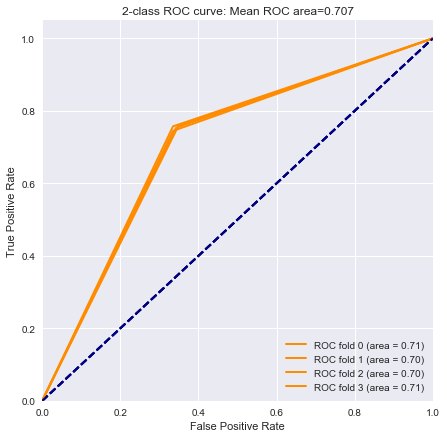

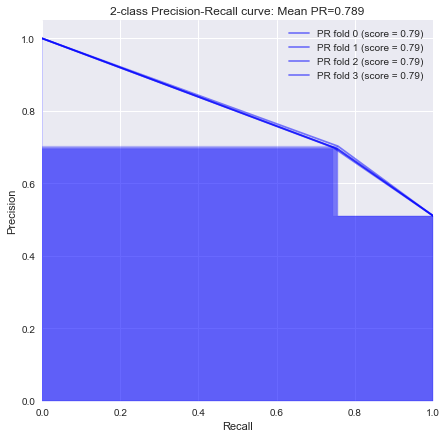

In [18]:
# кросс-валидация XGBoost на полном наборе данных:
gbm = xgb.XGBClassifier()
y_scores, y_tests = KFold(gbm, x_data, y_data)
ROC(y_scores, y_tests)
PRC(y_scores, y_tests)

In [19]:
# обучение на полном наборе данных и прогноз для Kaggle
#(необходимо тк при кросс-валидации модель была обучена на 4/5 датасета)
gbm = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1).fit(x_data, y_data)
pred_answers = gbm.predict(x_test_kaggle)
answers = pd.DataFrame({'ID':range(0, len(pred_answers)), 'result':pred_answers})
answers.to_csv('./answers_XGBoost.csv', sep = ',', index=False)

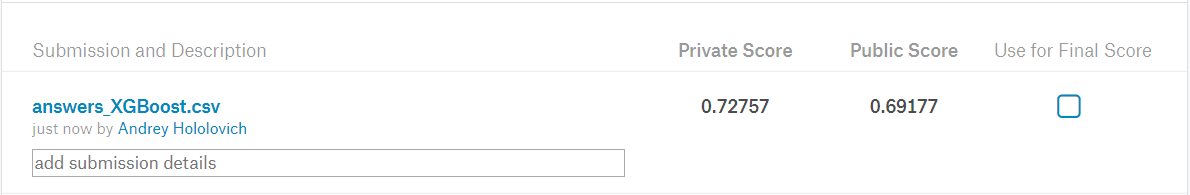

In [20]:
from IPython.display import Image
with open("./Kaggle_1.png",'rb') as f:
    display(Image(data=f.read(), format='png'))


,importance,labels
114,0.134393,Var125
199,0.059249,Var216
69,0.046243,Var80
101,0.046243,Var112
172,0.043353,Var188
63,0.039017,Var73
62,0.036127,Var72
182,0.028902,Var198
192,0.023121,Var209
46,0.021676,Var56


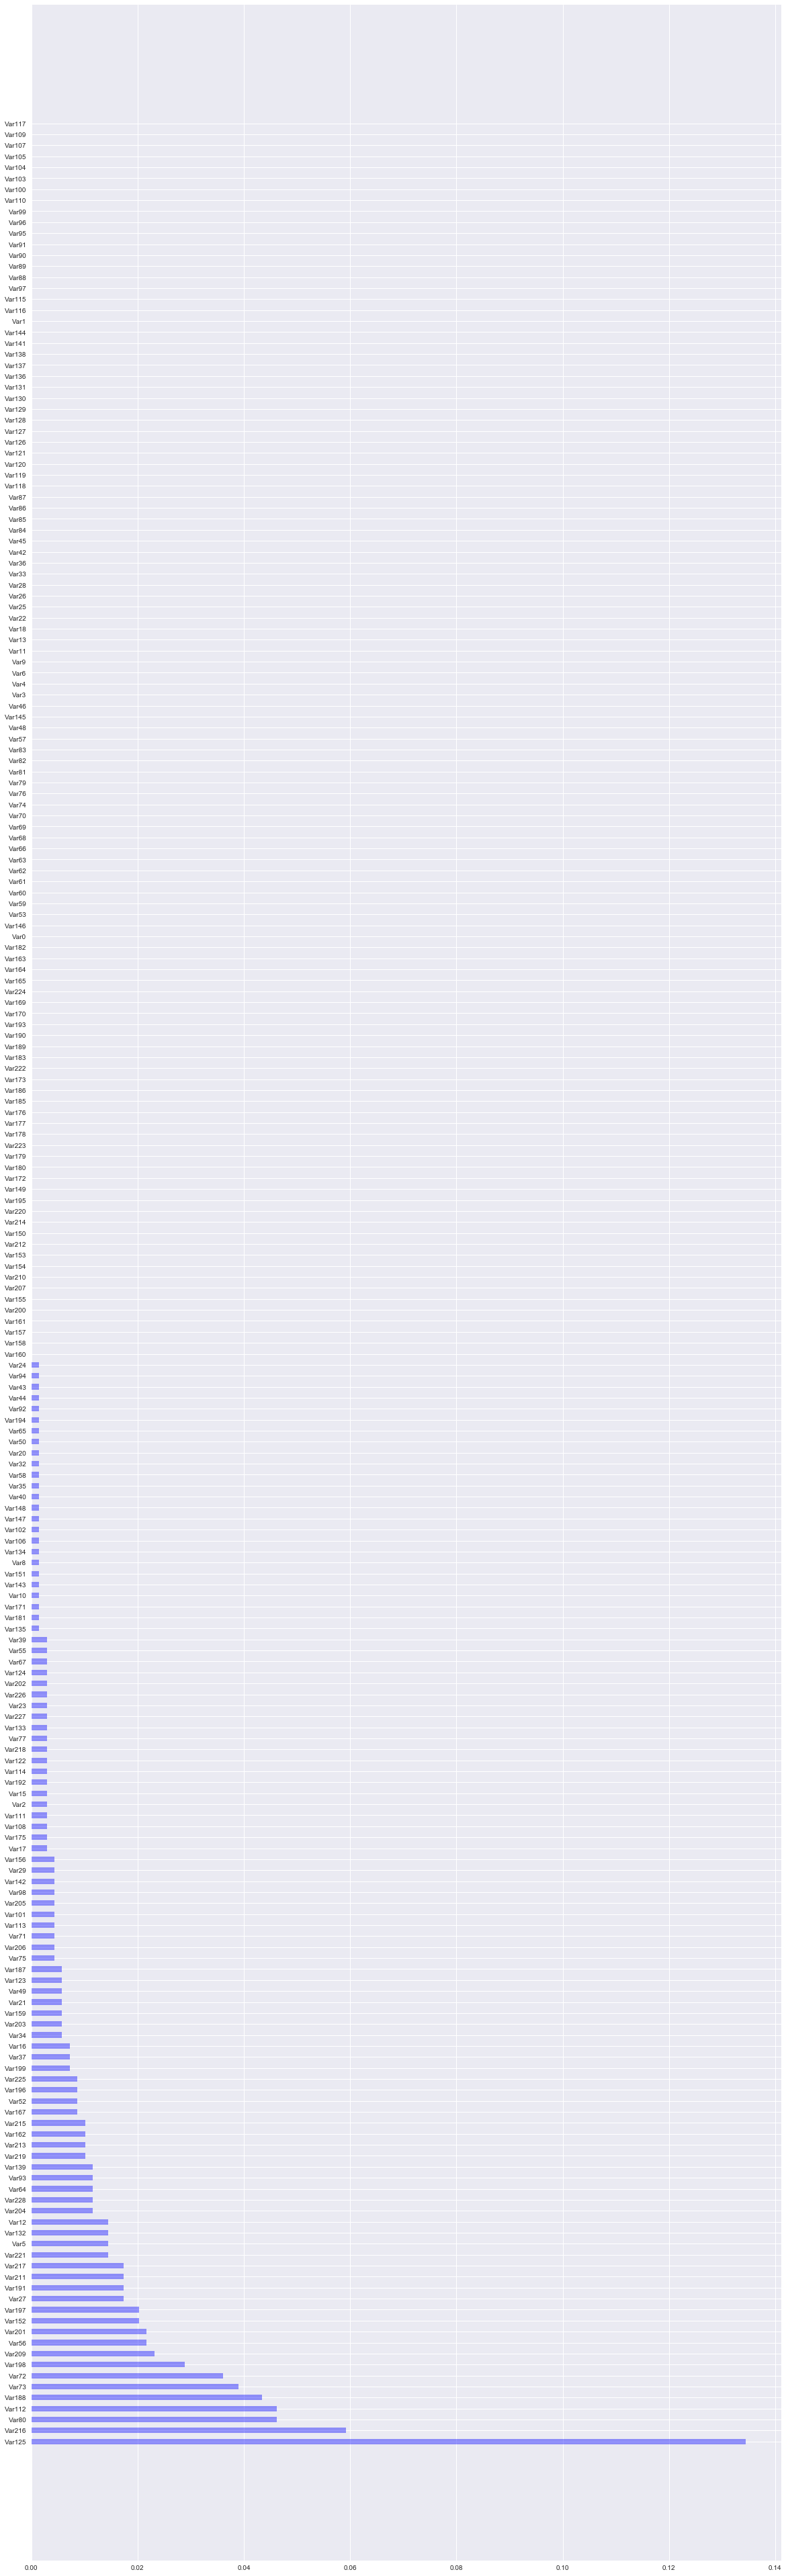

In [21]:
# отображение наиболее информативых фич для построенной модели
import_features = featureImportance(gbm, x_data)
best_features = import_features.iloc[:20, 1]

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


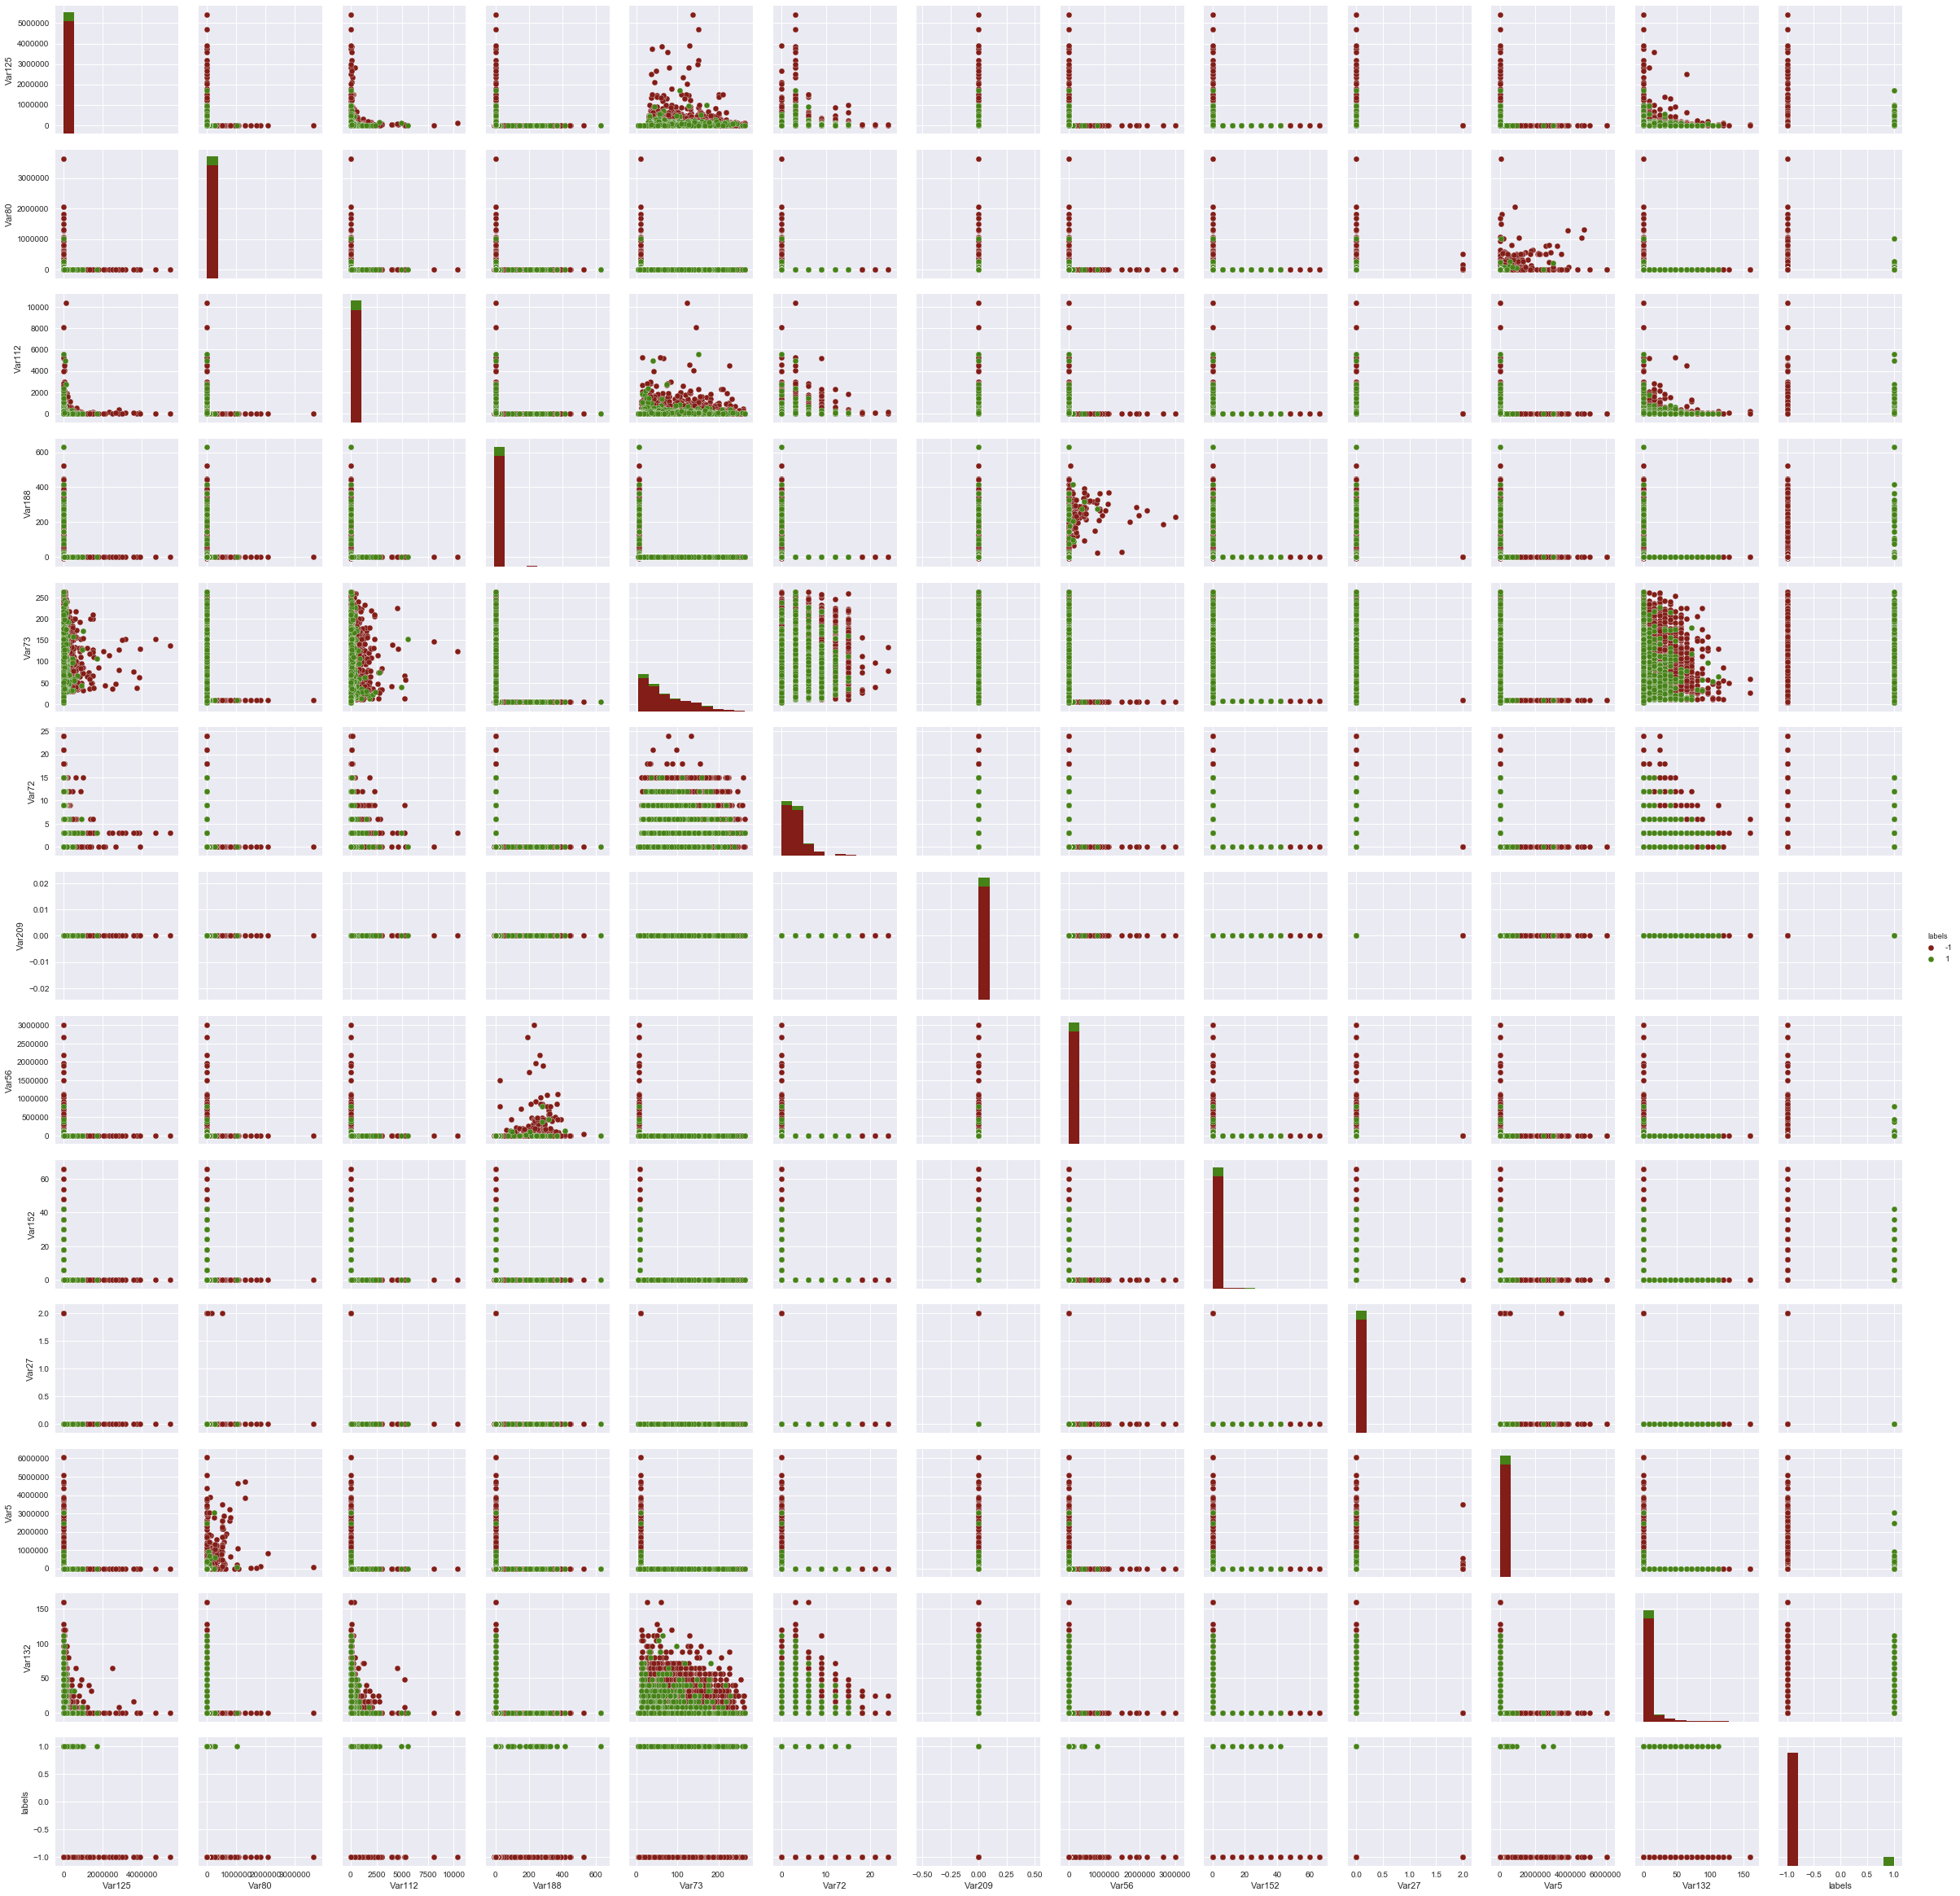

In [22]:
# посмотрим на наиболее информативные фичи:
import seaborn as sns
%pylab inline
best_features[len(best_features)] = ("labels")
sns_plot = sns.pairplot(train_data[best_features].dropna(), hue="labels",palette = sns.hls_palette(4, l=.3, s=.7))

Var125
Var216
Var80
Var112
Var188
Var73
Var72
Var198
Var209
Var56


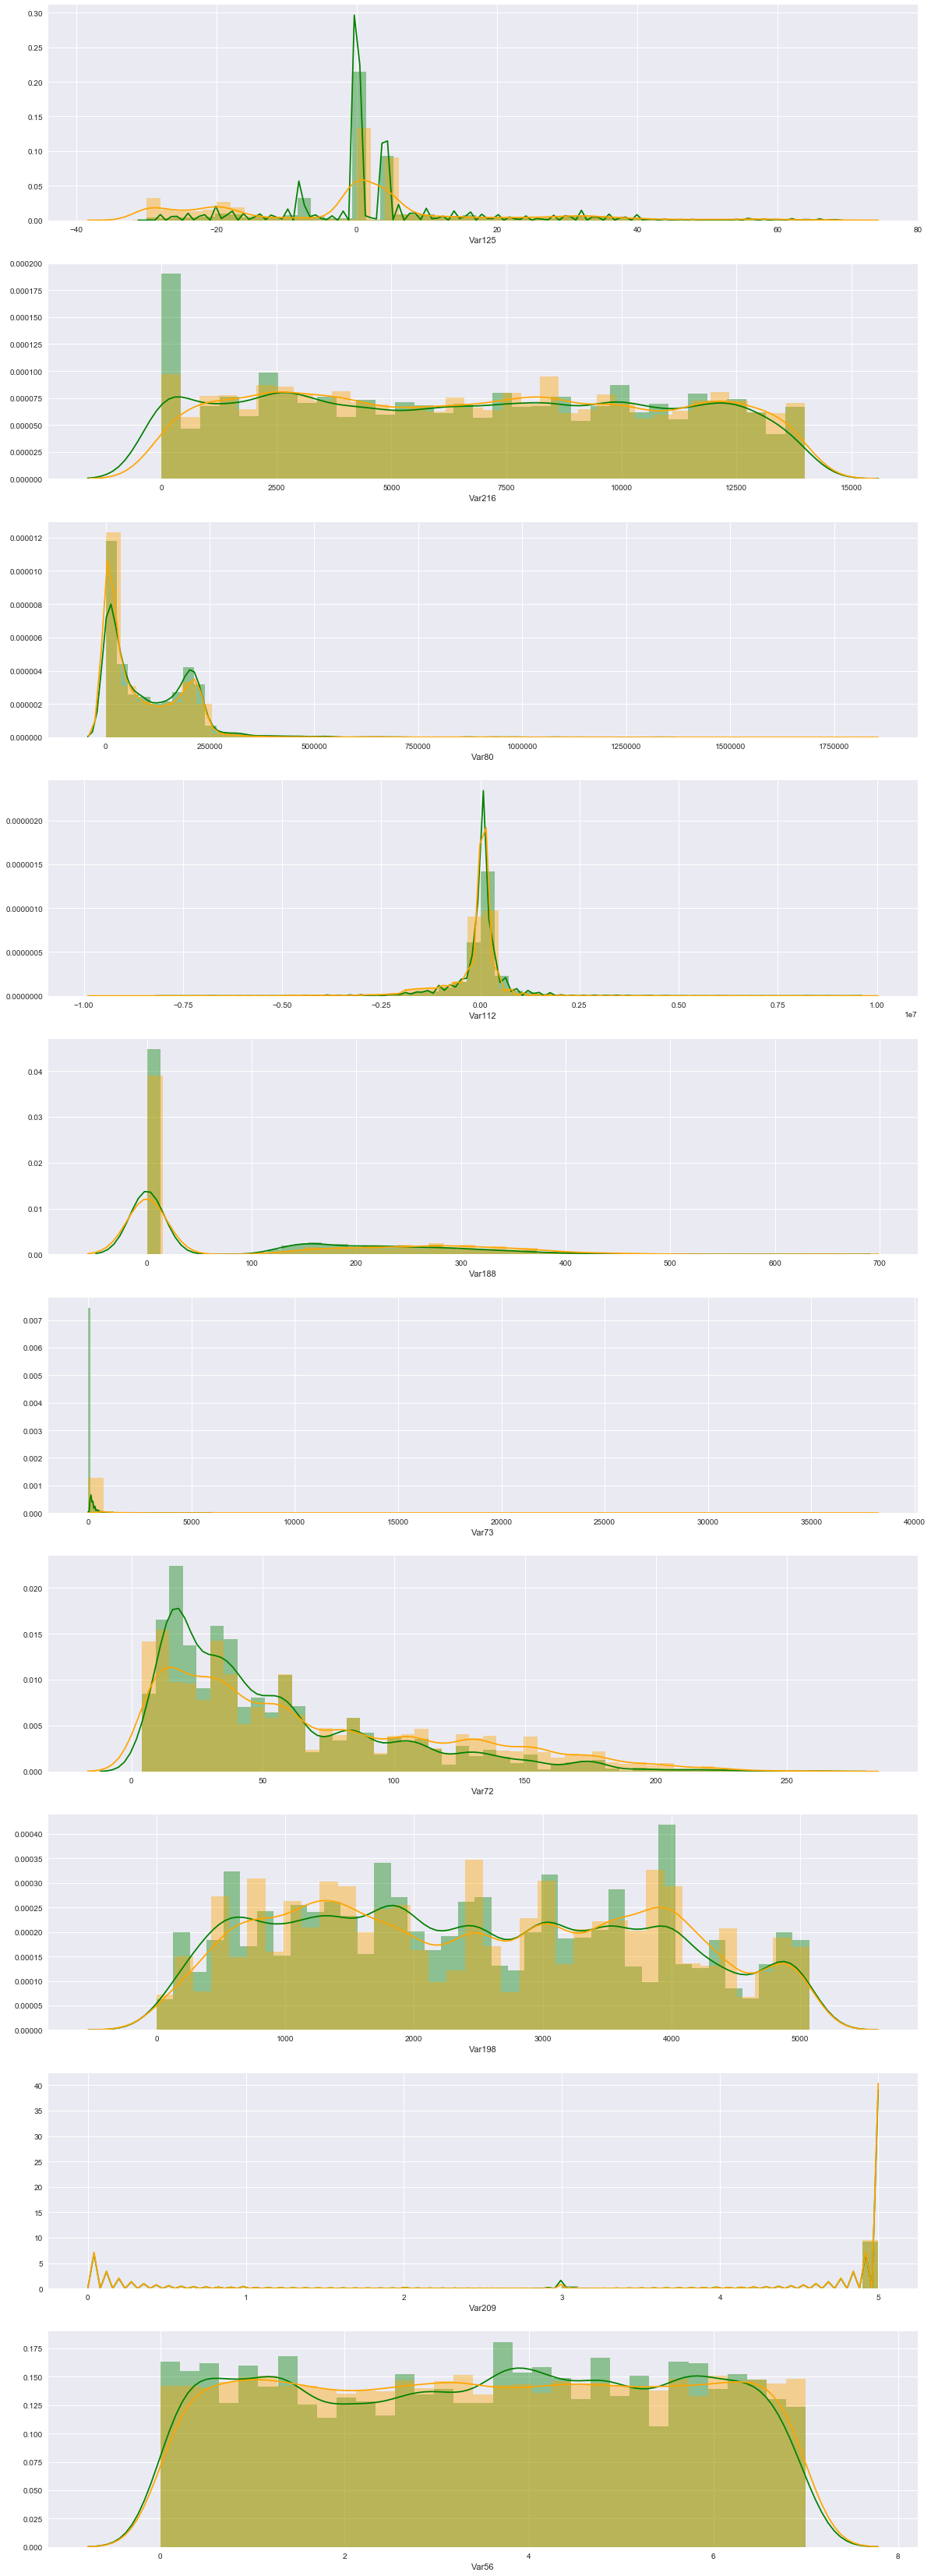

In [23]:
fig, axs = plt.subplots(10, figsize = (20,60))
sns.set(color_codes=True)

for ax, column in zip(axs, best_features):
    print column
    sns.distplot(x_data[column][y_data['labels'] == 1], ax = ax, color = "green", label = str(column)+" label = 1")
    sns.distplot(x_data[column][y_data['labels'] == -1], ax = ax, color = "orange", label = str(column)+" label = -1")

Более половины фич являются неинформативными для построенной модели, большинство из топа фич по информативности являются категориальными, что видно в графиках.
Ради эксперимента обучим модель на 20 наиболее информативных фичах:

(56784, 20)
(18928, 20)
(56784, 20)
(18928, 20)
(56784, 20)
(18928, 20)
(56784, 20)
(18928, 20)
mean f1 score: 0.719858065026


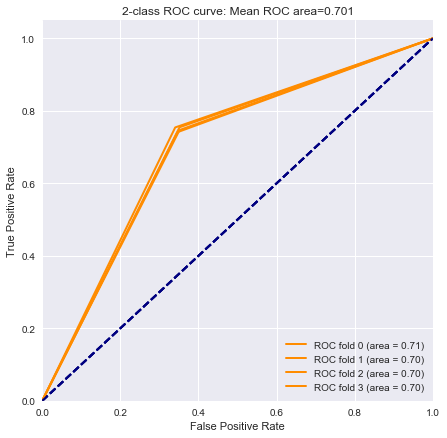

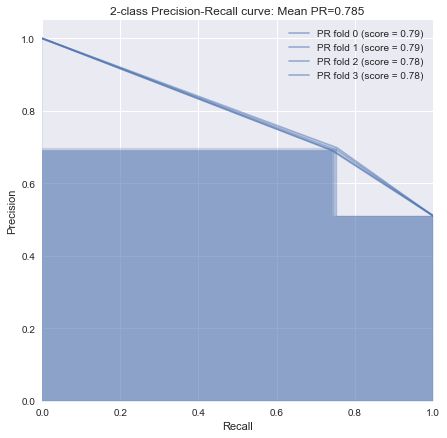

In [24]:
# XGBoost на 20 наиболее информативных фичах:
gbm = xgb.XGBClassifier()
y_scores, y_tests = KFold(gbm, x_data[best_features.iloc[:20]], y_data)
ROC(y_scores, y_tests)
PRC(y_scores, y_tests)

In [25]:
# обучение на полном наборе данных(на 20 фичах) и прогноз для Kaggle.
#(необходимо тк при кросс-валидации модель была обучена на 4/5 датасета)
gbm_20feat = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1).fit(x_data[best_features.iloc[:20]], y_data)
pred_answers = gbm_20feat.predict(x_test_kaggle[best_features.iloc[:20]])
answers = pd.DataFrame({'ID':range(0, len(pred_answers)), 'result':pred_answers})
answers.to_csv('./answers_XGBoost_20fatures.csv', sep = ',', index=False)

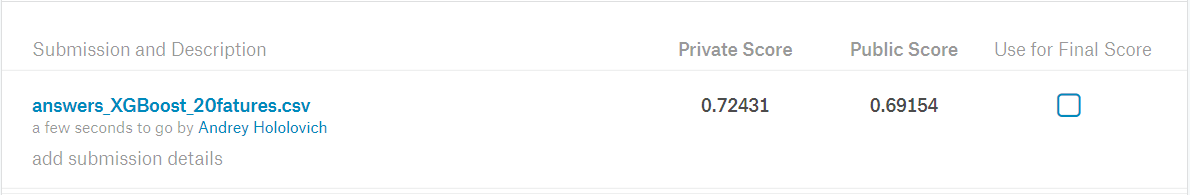

In [26]:
with open("./Kaggle_2.png",'rb') as f:
    display(Image(data=f.read(), format='png'))

Итог: модель на 20 фичах оказалась не намного хуже модели, построенной на полном датасете, из чего моджно сделать вывод, что большинство фич являются неинформативными (по крайней мере для данной модели). При отборе фич удалось увеличить скорость работы модели, тк размер данных уменьшился в несколько раз.

Модель построенная на 20 фичах оказалась лучше baseline решения на Kaggle. 